In [51]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score


In [6]:
df =pd.read_csv('Train.csv')
df.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [9]:
df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [11]:
df = df.drop(['item','store'],axis=1)
df.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [12]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date     datetime64[ns]
sales             int64
dtype: object

In [13]:
#conver date to month period 
#sum items in each month
df['date'] = df['date'].dt.to_period('M')
monthly_sales = df.groupby('date').sum().reset_index()

In [14]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [15]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


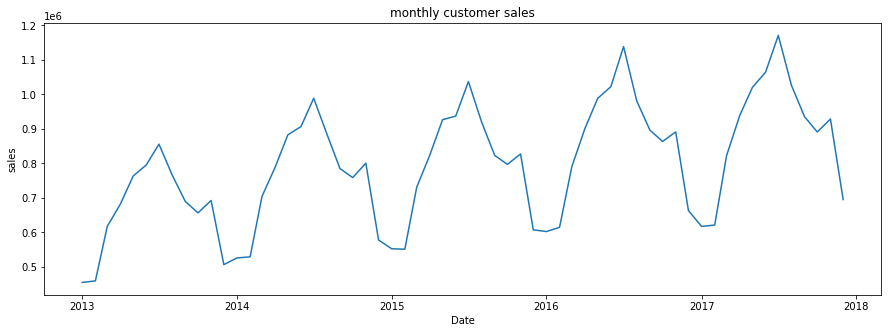

In [16]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel("sales")
plt.title('monthly customer sales')
plt.show()

In [17]:
#positive mean increase negative means decrease
monthly_sales ['sales_dif'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_dif
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


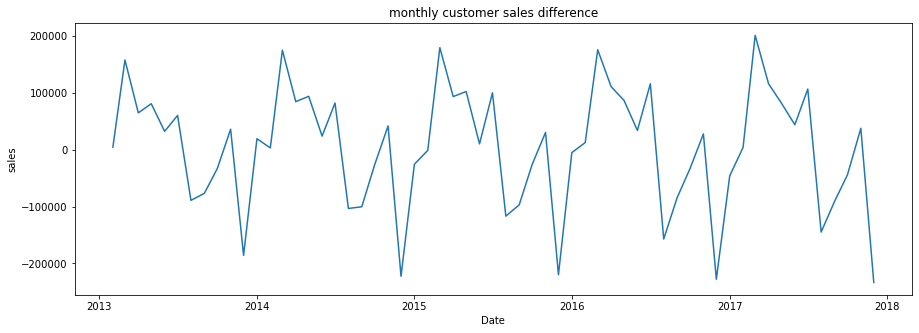

In [19]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales_dif'])
plt.xlabel('Date')
plt.ylabel("sales")
plt.title('monthly customer sales difference')
plt.show()

In [45]:
supervised_data = monthly_sales.drop(['date','sales'],axis=1)

In [46]:
for i in range (1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_dif'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_dif,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [54]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print (train_data.shape)
print (test_data.shape)

(35, 13)
(12, 13)


In [56]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [64]:
x_train ,y_train = train_data[:,1:],train_data[:,0:1]
x_test ,y_test = test_data[:,1:],test_data[:,0:1]
y_train = y_train.ravel()#covert 2 d array to 1 d
y_test = y_test.ravel()

In [66]:
sales_date = monthly_sales['date'][-12:].reset_index(drop= True)
predict_df = pd.DataFrame(sales_date)

In [72]:
actual_sales = monthly_sales['sales'][-13:].to_list()
actual_sales

[663411,
 617306,
 621369,
 822667,
 938862,
 1020686,
 1064624,
 1171393,
 1026403,
 935263,
 891160,
 928837,
 695170]

In [73]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre = lr_model.predict(x_test)

In [75]:
lr_pre = lr_pre.reshape(-1,1)
#metrics contains input feature and predicted output
lr_pre_test_set = np.concatenate([lr_pre,x_test],axis = 1)
#we need to conver our values because it changed by minmax scaller
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [81]:
result_list=[]
for index in range (0,len(lr_pre_test_set)):
    result_list.append([index][0] +actual_sales[index])
lr_pre_series = pd.Series(result_list,name='linear prediction')
predict_df = predict_df.merge(lr_pre_series,left_index = True,right_index=True)

In [82]:
predict_df

,date,linear prediction
0,2017-01-01,663411
1,2017-02-01,617307
2,2017-03-01,621371
3,2017-04-01,822670
4,2017-05-01,938866
5,2017-06-01,1020691
6,2017-07-01,1064630
7,2017-08-01,1171400
8,2017-09-01,1026411
9,2017-10-01,935272


In [86]:
lr_mse = np.sqrt(mean_squared_error(predict_df['linear prediction'],monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['linear prediction'],monthly_sales['sales'][-12:])
print("mean square error",lr_mse)
print("mean_absolute_error",lr_mae)


mean square error 116721.8764974387
mean_absolute_error 95981.08333333333


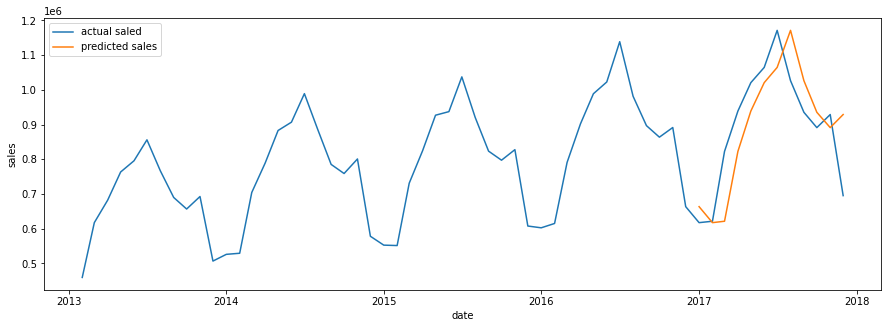

In [87]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.plot(predict_df['date'],predict_df['linear prediction'])
plt.xlabel('date')
plt.ylabel('sales')
plt.legend(["actual saled",'predicted sales'])